┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


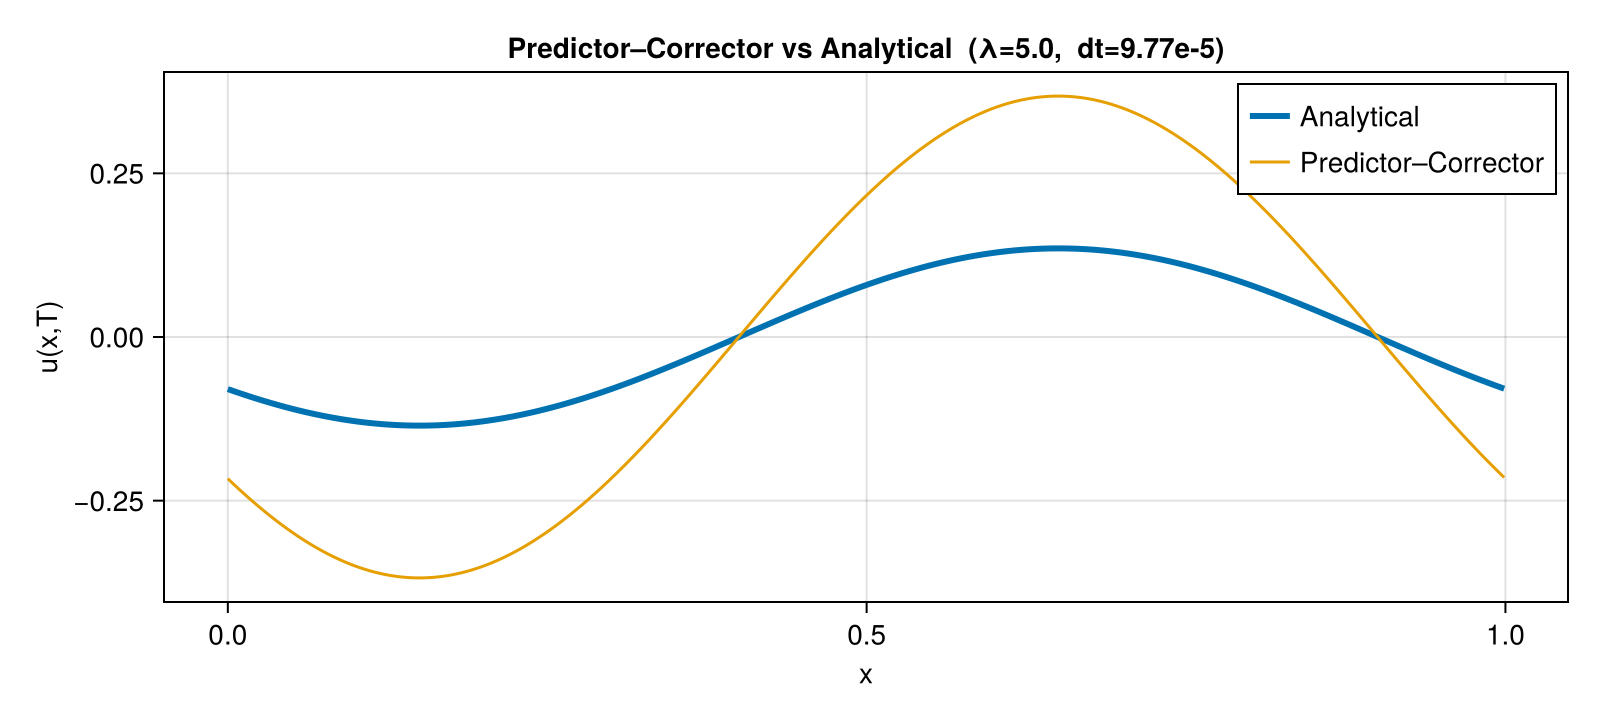

CairoMakie.Screen{IMAGE}


In [32]:
using CairoMakie

# --- PDE params ---
const λ = 5.0
const Lx = 1.0

# periodic index helpers
@inline prev(i, N) = (i == 1 ? N : i-1)
@inline nexti(i, N) = (i == N ? 1 : i+1)

# build interface fluxes from cell-centered u (your averaging rule)
function flux_interfaces!(F::Vector{Float64}, u::Vector{Float64})
    N = length(u)
    @inbounds for i in 1:N
        ip = nexti(i,N)
        uhalf = 0.5*(u[i] + u[ip])
        F[i] = uhalf                 # f(u)=u
    end
    return F
end

# one full predictor–corrector step (your formulas)
function step_predictor_corrector!(u::Vector{Float64}, dt::Float64, dx::Float64)
    N = length(u)
    uh = similar(u)     # half-time state
    F  = similar(u)     # flux at cell faces i+1/2 (wrapped)
    Fh = similar(u)

    # S^n = -λ u^n
    # predictor: compute F^n, then u^{n+1/2}
    flux_interfaces!(F, u)
    @inbounds for i in 1:N
        im = prev(i,N)
        divF = (F[im] - F[i]) / dx           # [F_{i-1/2} - F_{i+1/2}]/dx
        uh[i] = u[i] + 0.5*dt*divF + 0.5*dt*(-λ*u[i])
    end

    # corrector: compute F^{n+1/2} from uh, then final u^{n+1}
    flux_interfaces!(Fh, uh)
    @inbounds for i in 1:N
        im = prev(i,N)
        divFh = (Fh[im] - Fh[i]) / dx
        u[i] = u[i] + dt*divFh + 0.5*dt*(-λ*uh[i])  # uses + (Δt/2) S^{n+1/2} as you wrote
    end
    return u
end

# driver
function solve_predictor_corrector(; N=1024, T=0.4, CFL= 0.1)
    x  = range(0, Lx, length=N+1)[1:end-1]
    dx = Lx/N
    dt = CFL*dx             # a=1 ⇒ dt = CFL*dx
    nsteps = ceil(Int, T/dt)
    dt = T/nsteps           # land exactly at T

    u = sin.(2π .* x)       # initial condition
    for _ in 1:nsteps
        step_predictor_corrector!(u, dt, dx)
    end
    return x, u, dt, nsteps
end

# analytic solution
analytic(x, T) = exp(-λ*T) .* sin.(2π .* (x .- T))

# run & plot
x, u_num_pc, dt, nsteps = solve_predictor_corrector()
u_ex = analytic(x, nsteps*dt)

fig = Figure(resolution=(800,360))
ax  = Axis(fig[1,1], xlabel="x", ylabel="u(x,T)",
           title = "Predictor–Corrector vs Analytical  (λ=$(λ),  dt=$(round(dt,sigdigits=3)))")
lines!(ax, x, u_ex,  linewidth=3, label="Analytical")
lines!(ax, x, u_num_pc, label="Predictor–Corrector")
axislegend(ax, position=:rt)
#hidespines!(ax, :top, :right)
display(fig)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


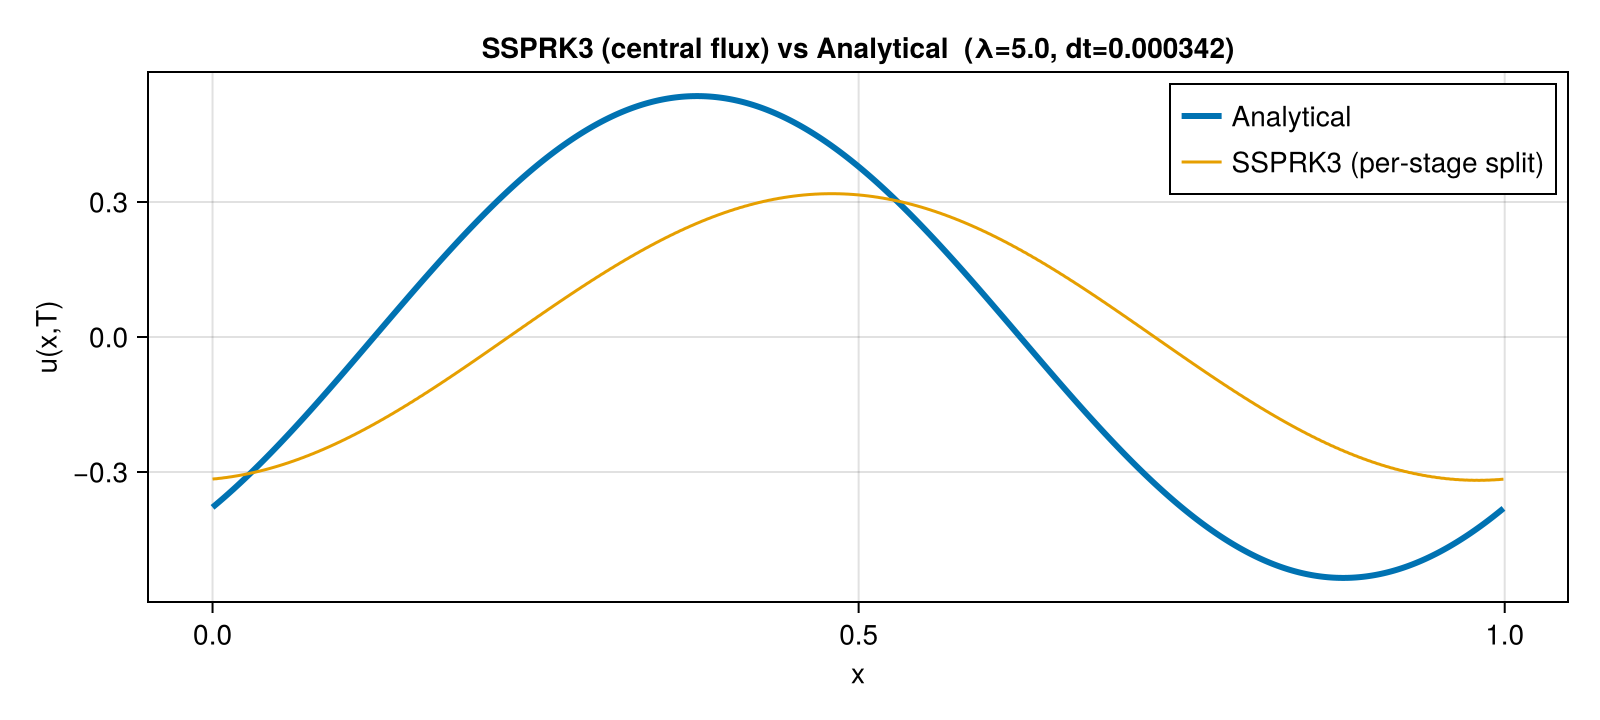

CairoMakie.Screen{IMAGE}


In [33]:
using CairoMakie

# ----- PDE params -----
const λ = 5.0
const Lx = 1.0

# periodic index helpers
@inline prev(i, N)  = (i == 1 ? N : i-1)
@inline nexti(i, N) = (i == N ? 1 : i+1)

# central interface flux: u_{i+1/2} = 0.5*(u_i + u_{i+1}), f(u)=u
function flux_interfaces!(F::Vector{Float64}, u::Vector{Float64})
    N = length(u)
    @inbounds for i in 1:N
        ip = nexti(i,N)
        uhalf = 0.5*(u[i] + u[ip])
        F[i] = uhalf
    end
    return F
end

# explicit advection step for one stage using central flux
function advect_central!(u::Vector{Float64}, dt::Float64, dx::Float64)
    N = length(u)
    F = similar(u)
    flux_interfaces!(F, u)
    du = similar(u)
    @inbounds for i in 1:N
        im = prev(i,N)
        du[i] = (F[im] - F[i]) / dx           # [F_{i-1/2} - F_{i+1/2}]/dx
    end
    @. u = u + dt * du
    return u
end

# exact stiff map: u <- e^{-λ dt} u
@inline stiff_exact!(u::Vector{Float64}, dt::Float64) = (@. u = exp(-λ*dt) * u)

# SSPRK3 with per-stage split: [advect → stiff] at each stage
function step_ssprk3_split!(u::Vector{Float64}, dt::Float64, dx::Float64)
    u0 = copy(u)

    # stage 1
    advect_central!(u, dt, dx)
    stiff_exact!(u, dt)

    # stage 2
    @. u = 0.75*u0 + 0.25*u
    advect_central!(u, dt, dx)
    stiff_exact!(u, dt)

    # stage 3
    @. u = (1/3)*u0 + (2/3)*u
    advect_central!(u, dt, dx)
    stiff_exact!(u, dt)

    return u
end

# driver
function solve_ssprk3(; N=1024, T=1/8, CFL= 0.35)  # keep CFL modest for central flux
    x  = range(0, Lx, length=N+1)[1:end-1]
    dx = Lx/N
    dt = CFL*dx                # a = 1 ⇒ dt = CFL*dx
    nsteps = ceil(Int, T/dt)
    dt = T/nsteps              # land exactly at T

    u = sin.(2π .* x)
    for _ in 1:nsteps
        step_ssprk3_split!(u, dt, dx)
    end
    return x, u, dt
end

# analytic solution
analytic(x, T) = exp(-λ*T) .* sin.(2π .* (x .- T))

# run & plot
x, u_num, dt = solve_ssprk3()
u_ex = analytic(x, dt*round(Int, (1/8)/dt))

fig = Figure(resolution=(800,360))
ax  = Axis(fig[1,1], xlabel="x", ylabel="u(x,T)",
           title = "SSPRK3 (central flux) vs Analytical  (λ=$(λ), dt=$(round(dt,sigdigits=3)))")
lines!(ax, x, u_ex,  linewidth=3, label="Analytical")
lines!(ax, x, u_num, label="SSPRK3 (per-stage split)")
axislegend(ax, position=:rt)
#hidespines!(ax, :top, :right)
display(fig)



┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


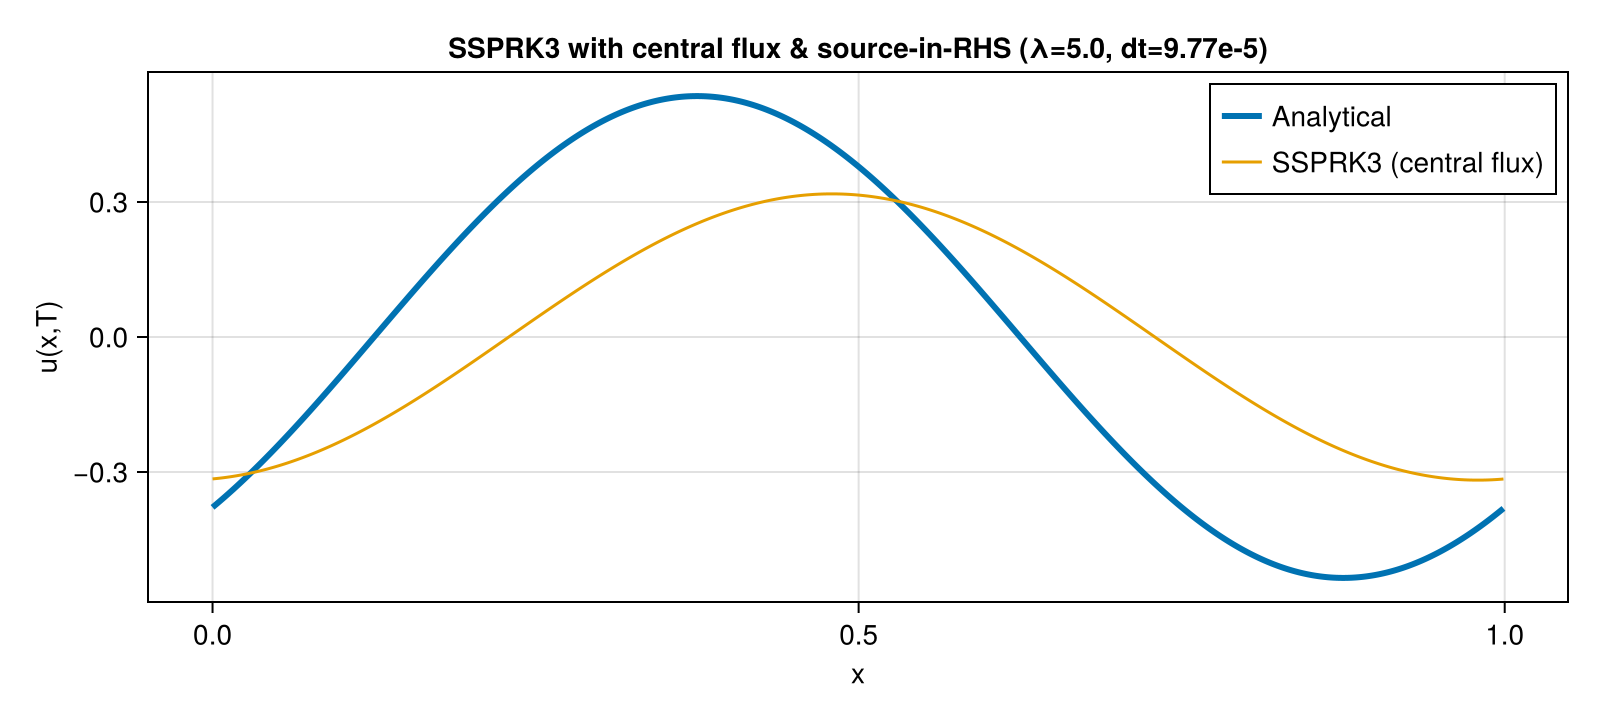

CairoMakie.Screen{IMAGE}


In [34]:
using CairoMakie

# PDE: u_t + u_x = -λ u on x∈[0,1], periodic
const λ = 5.0
const Lx = 1.0

@inline prev(i,N)  = (i==1 ? N : i-1)
@inline nexti(i,N) = (i==N ? 1 : i+1)

# central interface flux: F_{i+1/2} = u_{i+1/2} = 0.5*(u_i + u_{i+1})
function flux_interfaces!(F::Vector{Float64}, u::Vector{Float64})
    N = length(u)
    @inbounds for i in 1:N
        ip = nexti(i,N)
        F[i] = 0.5*(u[i] + u[ip])
    end
    return F
end

# ---------- Euler stage (your rhs-as-step) ----------
# u <- u + dt * ( (F_{i-1/2}-F_{i+1/2})/dx + S(u) ),  with S(u) = -λ u
function euler_stage!(u::Vector{Float64}, dt::Float64, dx::Float64)
    N  = length(u)
    F  = similar(u)
    du = similar(u)

    flux_interfaces!(F, u)
    @inbounds for i in 1:N
        im = prev(i,N)
        divF = (F[im] - F[i]) / dx
        du[i] = divF - λ*u[i]          # divF + S(u) with S = -λ u
    end
    @. u = u + dt*du
    return u
end

# ---------- SSPRK3 using that Euler stage ----------
function step_ssprk3!(u::Vector{Float64}, dt::Float64, dx::Float64)
    u0 = copy(u)
    # stage 1
    euler_stage!(u, dt, dx)
    # stage 2
    @. u = 0.75*u0 + 0.25*u
    euler_stage!(u, dt, dx)
    # stage 3
    @. u = (1/3)*u0 + (2/3)*u
    euler_stage!(u, dt, dx)
    return u
end

# Driver
function solve_ssprk3(; N=1024, T=1/8, CFL=0.1)  # small CFL for central flux
    x  = range(0, Lx, length=N+1)[1:end-1]
    dx = Lx/N
    dt = CFL*dx                 # a=1 → dt = CFL*dx
    nsteps = ceil(Int, T/dt)
    dt = T/nsteps               # land exactly at T

    u = sin.(2π .* x)           # IC
    for _ in 1:nsteps
        step_ssprk3!(u, dt, dx)
    end
    return x, u, dt, nsteps
end

# Analytical solution
analytic(x,t) = exp(-λ*t) .* sin.(2π .* (x .- t))

# Run & plot
x, u_num_ssprk3, dt, nsteps = solve_ssprk3()
u_ex = analytic(x, nsteps*dt)

fig = Figure(resolution=(800,360))
ax  = Axis(fig[1,1], xlabel="x", ylabel="u(x,T)",
           title = "SSPRK3 with central flux & source-in-RHS (λ=$(λ), dt=$(round(dt,sigdigits=3)))")
lines!(ax, x, u_ex,  linewidth=3, label="Analytical")
lines!(ax, x, u_num_ssprk3, label="SSPRK3 (central flux)")
axislegend(ax, position=:rt)
#hidespines!(ax, :top, :right)
display(fig)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


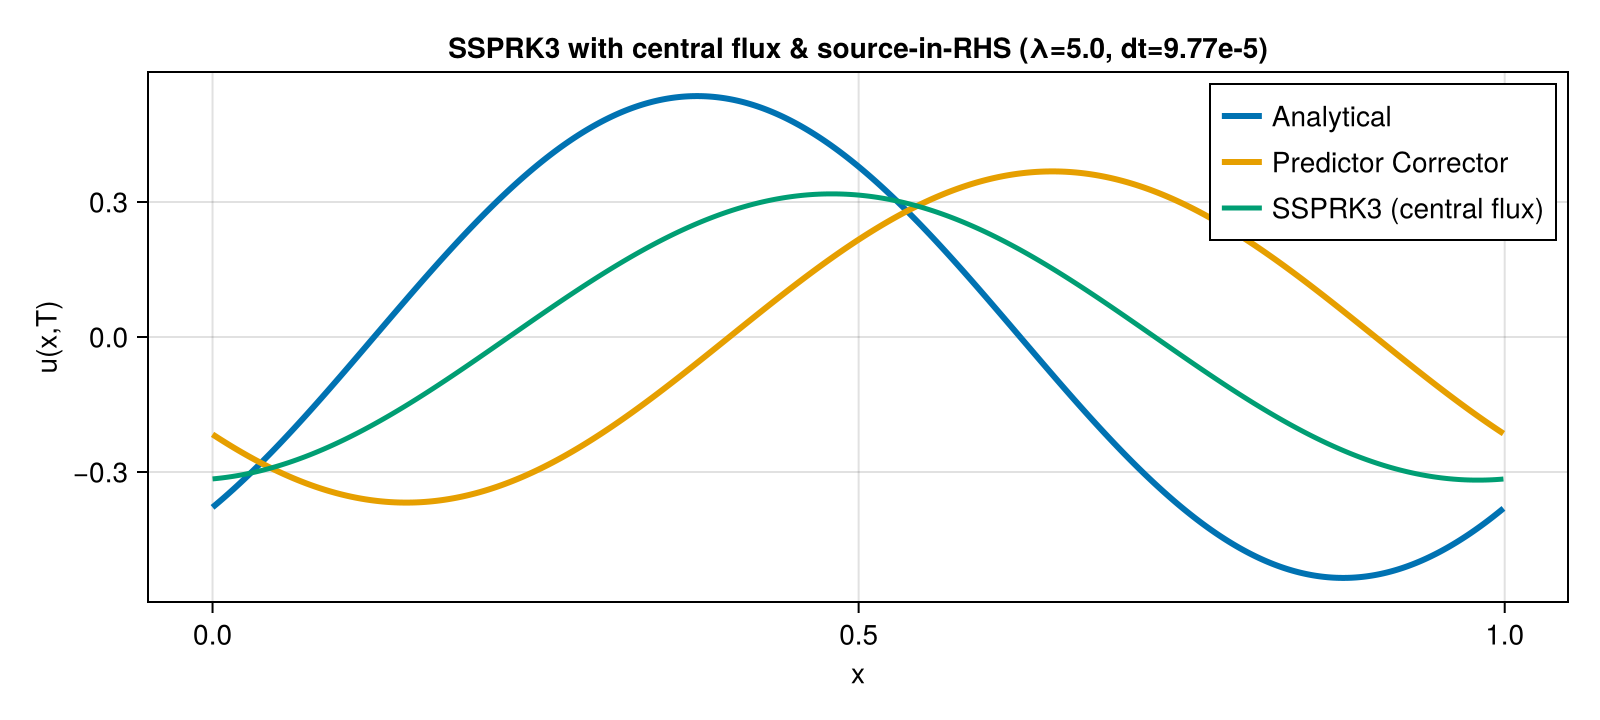

CairoMakie.Screen{IMAGE}


In [35]:
fig = Figure(resolution=(800,360))
ax  = Axis(fig[1,1], xlabel="x", ylabel="u(x,T)",
           title = "SSPRK3 with central flux & source-in-RHS (λ=$(λ), dt=$(round(dt,sigdigits=3)))")
lines!(ax, x, u_ex,  linewidth=3, label="Analytical")
lines!(ax, x, u_num_pc,  linewidth=3, label="Predictor Corrector")
lines!(ax, x, u_num_ssprk3,linewidth = 2.5, label="SSPRK3 (central flux)")
axislegend(ax, position=:rt)
#hidespines!(ax, :top, :right)
display(fig)

# Pre-Cor and SSPRK3 Comparison with minmod

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


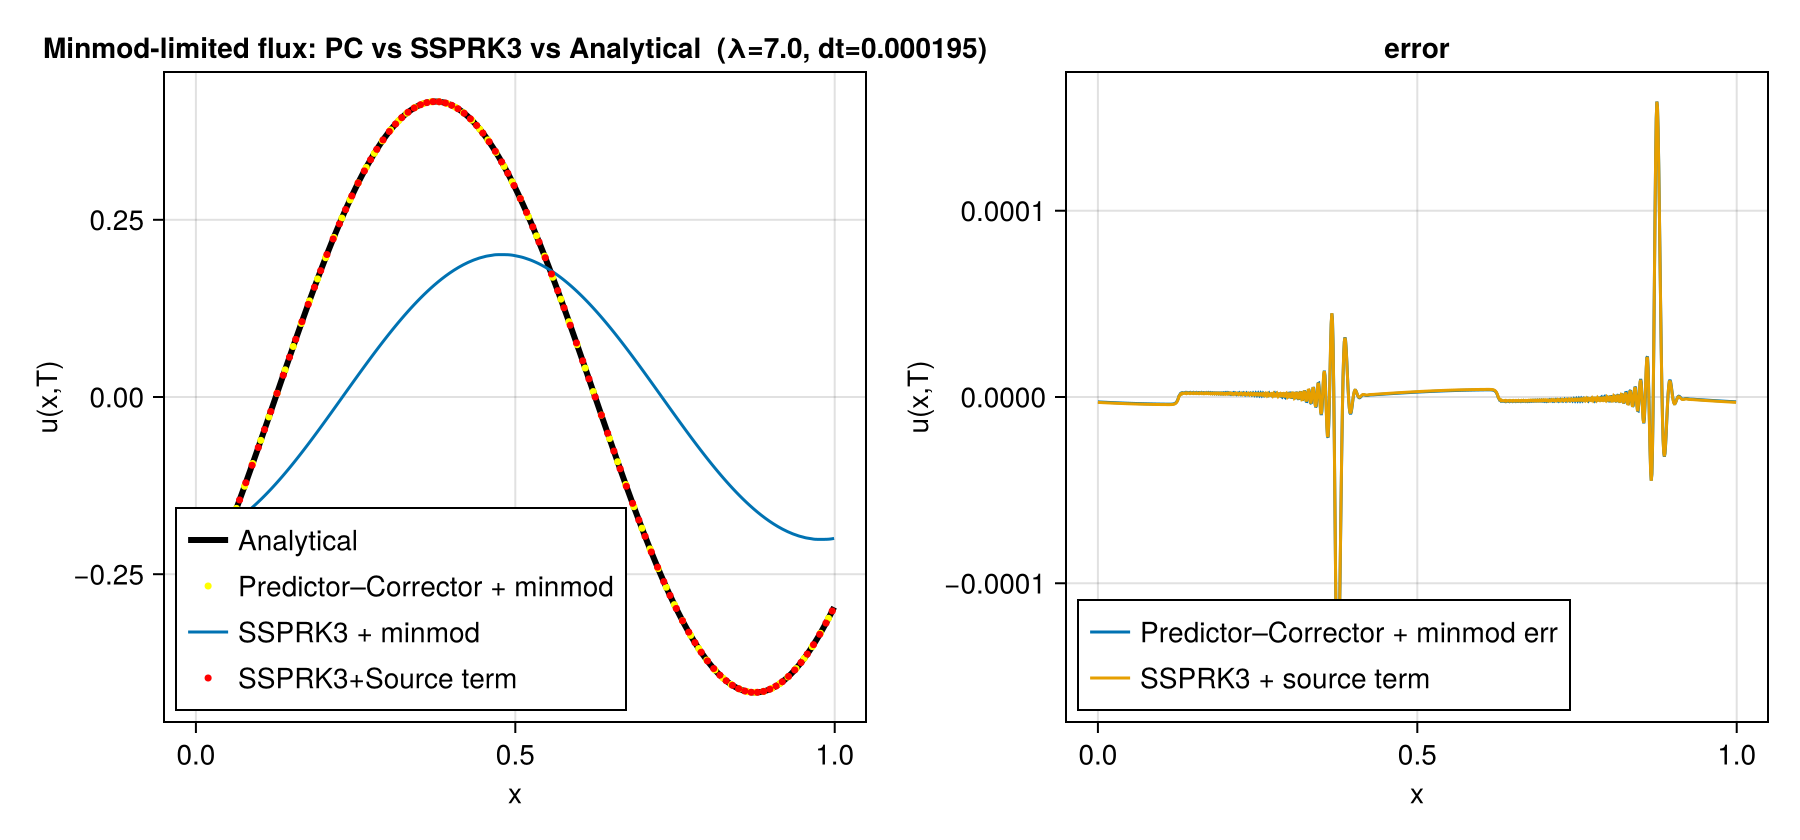

CairoMakie.Screen{IMAGE}


In [100]:
using CairoMakie

# ----- PDE & grid helpers -----
const λ = 7.0
const Lx = 1.0
@inline prev(i,N)  = (i==1  ? N : i-1)
@inline nexti(i,N) = (i==N  ? 1 : i+1)

# ----- Minmod limiter -----
@inline function minmod(a,b)
    (a*b <= 0) && return 0.0
    return sign(a)*min(abs(a), abs(b))
end

"""
    reconstruct_minmod(u, dx) -> uL, uR

Cell-centered u -> slope-limited linear recon.
Returns:
  uL[i] = left state at face i+1/2 (from cell i)
  uR[i] = right state at face i-1/2 (from cell i)
"""
function reconstruct_minmod(u::Vector{Float64}, dx::Float64)
    N  = length(u)
    uL = similar(u)   # at i+1/2 from cell i
    uR = similar(u)   # at i-1/2 from cell i
    @inbounds for i in 1:N
        im, ip = prev(i,N), nexti(i,N)
        σ = minmod( (u[i]-u[im])/dx, (u[ip]-u[i])/dx )
        uL[i] = u[i] + 0.5*σ*dx
        uR[i] = u[i] - 0.5*σ*dx
    end
    return uL, uR
end

# ----- Flux from reconstructed states (a = +1 → upwind = left state) -----
# F[i] is flux at face i+1/2
function flux_faces_minmod!(F::Vector{Float64}, u::Vector{Float64}, dx::Float64)
    N = length(u)
    uL, _ = reconstruct_minmod(u, dx)
    @inbounds for i in 1:N
        F[i] = uL[i]          # f(u)=u, upwind with a=+1
    end
    return F
end

# ===================== 1) Predictor–Corrector (PC) =====================

"""
Predictor–Corrector with minmod flux:
  u^{n+1/2} = u^n + (dt/2Δx)[F^n_{i-1/2}-F^n_{i+1/2}] + (dt/2)S^n
  u^{n+1}   = u^n + (dt/Δx )[F^{n+1/2}_{i-1/2}-F^{n+1/2}_{i+1/2}] + (dt/2)S^{n+1/2}
with S = -λ u.
"""
# function step_predictor_corrector_minmod!(u::Vector{Float64}, dt::Float64, dx::Float64)
#     N  = length(u)
#     F  = similar(u)
#     Fh = similar(u)
#     uh = similar(u)

#     # predictor (n → n+1/2)
#     flux_faces_minmod!(F, u, dx)
#     @inbounds for i in 1:N
#         im = prev(i,N)
#         divF = (F[im] - F[i]) / dx
#         uh[i] = u[i] + 0.5*dt*divF + 0.5*dt*(-λ*u[i])
#     end

#     # corrector (use uh at half time)
#     flux_faces_minmod!(Fh, uh, dx)
#     @inbounds for i in 1:N
#         im = prev(i,N)
#         divFh = (Fh[im] - Fh[i]) / dx
#         u[i] = u[i] + dt*divFh + 0.5*dt*(-λ*uh[i])
#     end
#     return u
# end
function step_predictor_corrector_minmod!(u::Vector{Float64}, dt::Float64, dx::Float64)
    N  = length(u)
    F  = similar(u)
    Fh = similar(u)
    uh = similar(u)

    # predictor (n → n+1/2)
    flux_faces_minmod!(F, u, dx)
    @inbounds for i in 1:N
        im = prev(i,N)
        divF = (F[im] - F[i]) / dx
        uh[i] = u[i] + 0.5*dt*divF + 0.5*dt*(-λ*u[i])  # S^n
    end

    # corrector - use S^{n+1/2} for full step
    flux_faces_minmod!(Fh, uh, dx)
    @inbounds for i in 1:N
        im = prev(i,N)
        divFh = (Fh[im] - Fh[i]) / dx
        u[i] = u[i] + dt*divFh + dt*(-λ*uh[i])  # S^{n+1/2} for full dt
    end
    return u
end

# ====================== 2) SSPRK3 (same limited flux) ===================

# One Euler stage: u += dt*(divF/Δx + S), with minmod-limited flux
function euler_stage_minmod!(u::Vector{Float64}, dt::Float64, dx::Float64)
    N  = length(u)
    F  = similar(u)
    du = similar(u)
    flux_faces_minmod!(F, u, dx)
    @inbounds for i in 1:N
        im = prev(i,N)
        divF = (F[im] - F[i]) / dx
        du[i] = divF - λ*u[i]
    end
    @. u = u + dt*du
    return u
end

function step_ssprk3_minmod!(u::Vector{Float64}, dt::Float64, dx::Float64)
    u0 = copy(u)
    # stage 1
    euler_stage_minmod!(u, dt, dx)
    # stage 2
    @. u = 0.75*u0 + 0.25*u
    euler_stage_minmod!(u, dt, dx)
    # stage 3
    @. u = (1/3)*u0 + (2/3)*u
    euler_stage_minmod!(u, dt, dx)
    return u
end

# ============================ Driver & Plot =============================

analytic(x,t) = exp(-λ*t) .* sin.(2π .* (x .- t))

function run_compare(; N=1024, T=1/8, CFL=0.2)  # upwind w/ limiter allows larger CFL (≤1)
    x  = range(0, Lx, length=N+1)[1:end-1]
    dx = Lx/N
    dt = CFL*dx
    nsteps = ceil(Int, T/dt); dt = T/nsteps

    u0 = sin.(2π .* x)
    u_pc   = copy(u0)
    u_ssp  = copy(u0)

    for _ in 1:nsteps
        step_predictor_corrector_minmod!(u_pc,  dt, dx)
        step_ssprk3_minmod!(u_ssp, dt, dx)
    end
    u_ex = analytic(x, nsteps*dt)

    fig = Figure(resolution=(900,420))
    ax  = Axis(fig[1,1], xlabel="x", ylabel="u(x,T)",
               title="Minmod-limited flux: PC vs SSPRK3 vs Analytical  (λ=$(λ), dt=$(round(dt,sigdigits=3)))")
    lines!(ax, x, u_ex,  linewidth=3, label="Analytical",color=:black)
    scatter!(ax, x[1:13:end], u_pc[1:13:end],markersize = 5.0,  label="Predictor–Corrector + minmod",color=:yellow)
    lines!(ax, x, u_ssp, label="SSPRK3 + minmod")
    scatter!(ax, x[1:10:end], uT[1:10:end],  markersize = 5.0,color =:red, label="SSPRK3+Source term")
    
    axislegend(ax, position=:lb)
    ax1 = Axis(fig[1,2], xlabel="x", ylabel="u(x,T)", title ="error")
    lines!(ax1, x, u_pc .- u_ex,  label="Predictor–Corrector + minmod err")
    #lines!(ax1, x, u_ssp .- u_ex, label="SSPRK3 + minmod err")
    lines!(ax1,x,uT .- u_ex, label ="SSPRK3 + source term")
    axislegend(ax1, position=:lb)
    #hidespines!(ax, :top, :right)
    display(fig)
end

# run
run_compare()


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


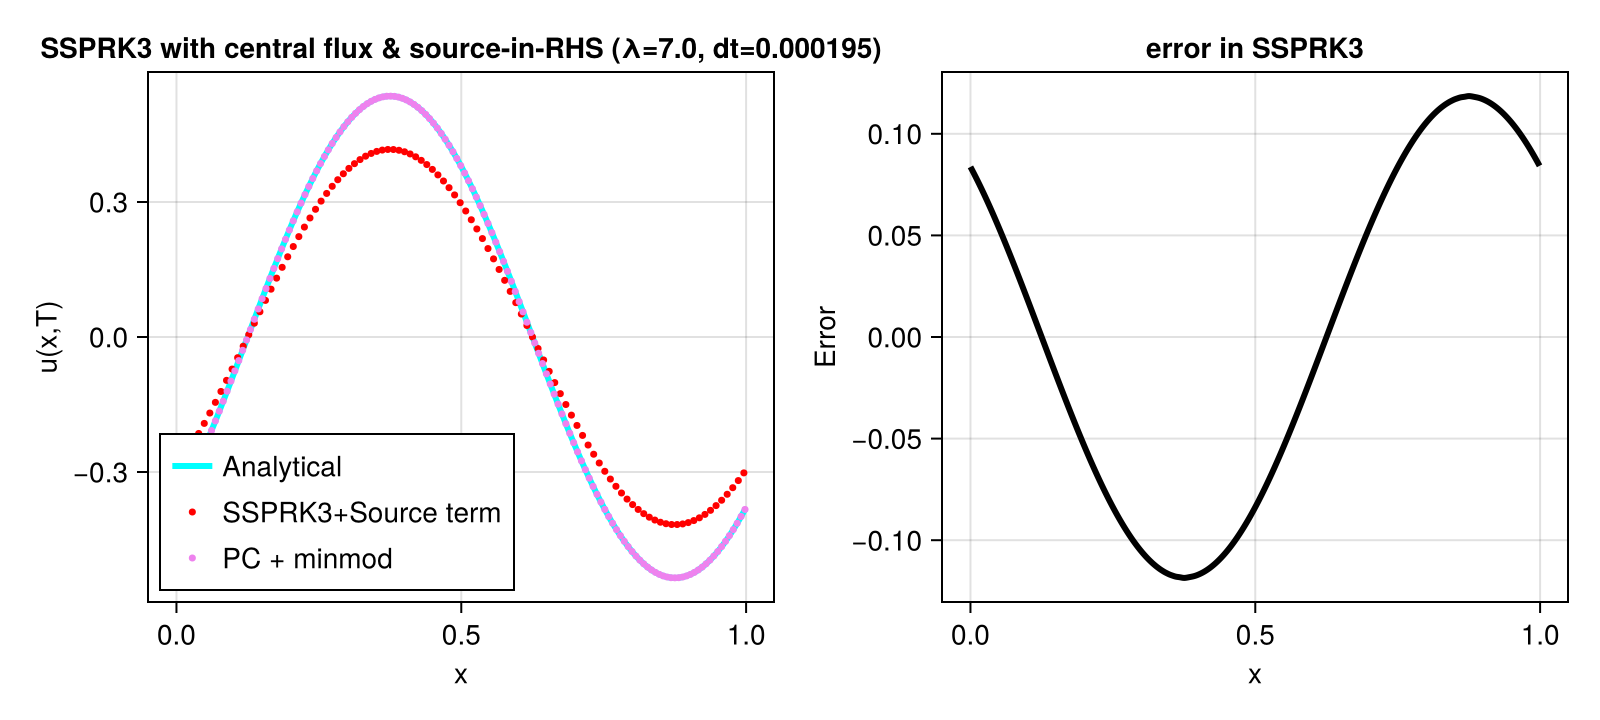

CairoMakie.Screen{IMAGE}


In [101]:
# ====== PDE & helpers ======
const λ  = 7.0               # source strength
const Lx = 1.0                # domain length

@inline prev(i,N)  = (i==1 ? N : i-1)
@inline nexti(i,N) = (i==N ? 1 : i+1)

@inline function minmod(a::Float64, b::Float64)
    (a*b <= 0.0) && return 0.0
    return sign(a) * min(abs(a), abs(b))
end

"""
reconstruct_minmod(u, dx) -> uL, uR

Slope-limited linear reconstruction per cell.
uL[i] = left state at face i+1/2 (from cell i)
uR[i] = right state at face i-1/2 (from cell i)
"""
function reconstruct_minmod(u::Vector{Float64}, dx::Float64)
    N  = length(u)
    uL = similar(u)
    uR = similar(u)
    @inbounds for i in 1:N
        im, ip = prev(i,N), nexti(i,N)
        σ = minmod((u[i]-u[im])/dx, (u[ip]-u[i])/dx)
        uL[i] = u[i] + 0.5*σ*dx
        uR[i] = u[i] - 0.5*σ*dx
    end
    return uL, uR
end

# F[i] is flux at face i+1/2, for a=+1 use upwind = left state
function flux_faces_minmod!(F::Vector{Float64}, u::Vector{Float64}, dx::Float64)
    N = length(u)
    uL, _ = reconstruct_minmod(u, dx)
    @inbounds for i in 1:N
        F[i] = uL[i]              # f(u)=u
    end
    return F
end

"""
rhs_minmod!(du, u, dx, t)

Computes RHS L(u,t) = (F_{i-1/2} - F_{i+1/2})/dx + S(u,t),
with S(u,t) = -λ u and minmod-limited upwind flux for f.
"""
function rhs_minmod!(du::Vector{Float64}, u::Vector{Float64}, dx::Float64, t::Float64)
    N = length(u)
    F = similar(u)
    flux_faces_minmod!(F, u, dx)
    @inbounds for i in 1:N
        im = prev(i,N)
        divF  = (F[im] - F[i]) / dx
        du[i] = divF - λ*u[i]
    end
    return du
end

# ====== SSPRK(3,3): your k1/k2/k3 staging exactly ======
"""
step_ssprk3_k123!(u, dt, dx, t)

Stage 1:
  k1 = f(y^n,t^n) + S(y^n,t^n)
  y^(1) = y^n + dt*k1
Stage 2:
  k2 = f(y^(1), t^n+dt) + S(y^(1), t^n+dt)
  y^(2) = 3/4 y^n + 1/4 y^(1) + 1/4 dt*k2
Stage 3:
  k3 = f(y^(2), t^n+dt/2) + S(y^(2), t^n+dt/2)
  y^{n+1} = 1/3 y^n + 2/3 y^(2) + 2/3 dt*k3
"""
function step_ssprk3_k123!(u::Vector{Float64}, dt::Float64, dx::Float64, t::Float64)
    k1 = similar(u); k2 = similar(u); k3 = similar(u)
    y1 = similar(u); y2 = similar(u)

    # Stage 1
    rhs_minmod!(k1, u, dx, t)              # k1 = f(y^n,t^n) + S(y^n,t^n)
    @. y1 = u + dt*k1                      # y^(1)

    # Stage 2
    rhs_minmod!(k2, y1, dx, t + dt)        # k2 at (y^(1), t^n+dt)
    @. y2 = (3/4)*u + (1/4)*y1 + (1/4)*dt*k2

    # Stage 3
    rhs_minmod!(k3, y2, dx, t + dt/2)      # k3 at (y^(2), t^n+dt/2)
    @. u  = (1/3)*u + (2/3)*y2 + (2/3)*dt*k3  # y^{n+1}

    return u
end

# ====== (optional) tiny driver to use it ======
"""
evolve_ssprk3_k123(u0; T, CFL)

Evolves u from t=0 to T on [0,1] with periodic BCs.
Grid spacing inferred from length(u0) and Lx.
"""
function evolve_ssprk3_k123(u0::Vector{Float64}; T::Float64=0.125, CFL::Float64=0.8)
    N  = length(u0)
    dx = Lx/N
    dt = CFL*dx                  # a=+1 ⇒ dt = CFL*dx
    nsteps = Int(ceil(T/dt)); dt = T/nsteps
    t = 0.0
    u = copy(u0)
    for _ in 1:nsteps
        step_ssprk3_k123!(u, dt, dx, t)
        t += dt
    end
    return u, t, dt
end
N = 1024
x = range(0, Lx, length=N+1)[1:end-1]
u0 = sin.(2π .* x)
uT, t, dt = evolve_ssprk3_k123(u0; T=1/8, CFL=0.2)

fig = Figure(resolution=(800,360))
ax  = Axis(fig[1,1], xlabel="x", ylabel="u(x,T)",
           title = "SSPRK3 with central flux & source-in-RHS (λ=$(λ), dt=$(round(dt,sigdigits=3)))")
lines!(ax, x, u_ex,  linewidth=3, label="Analytical",color=:cyan)
scatter!(ax, x[1:10:end], uT[1:10:end],  markersize = 5.0,color =:red, label="SSPRK3+Source term")
scatter!(ax, x[1:7:end], u_num_minmod[1:7:end],  markersize = 5.0,color =:violet, label="PC + minmod")

ax1 = Axis(fig[1,2], xlabel="x", ylabel="Error",title = "error in SSPRK3")
lines!(ax1,x, uT .- u_ex,linewidth = 3.0, label = "error",color=:black)
axislegend(ax, position=:lb,α = 0.2)
#hidespines!(ax, :top, :right)
display(fig)
#save("comp.svg",fig)

=== Minmod Predictor-Corrector Results ===
Max error: 0.0002036700682883641
L2 error: 0.000757236744074738
Time step: 0.0001953125
CFL number: 0.2
Final time: 0.12500000000000125


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


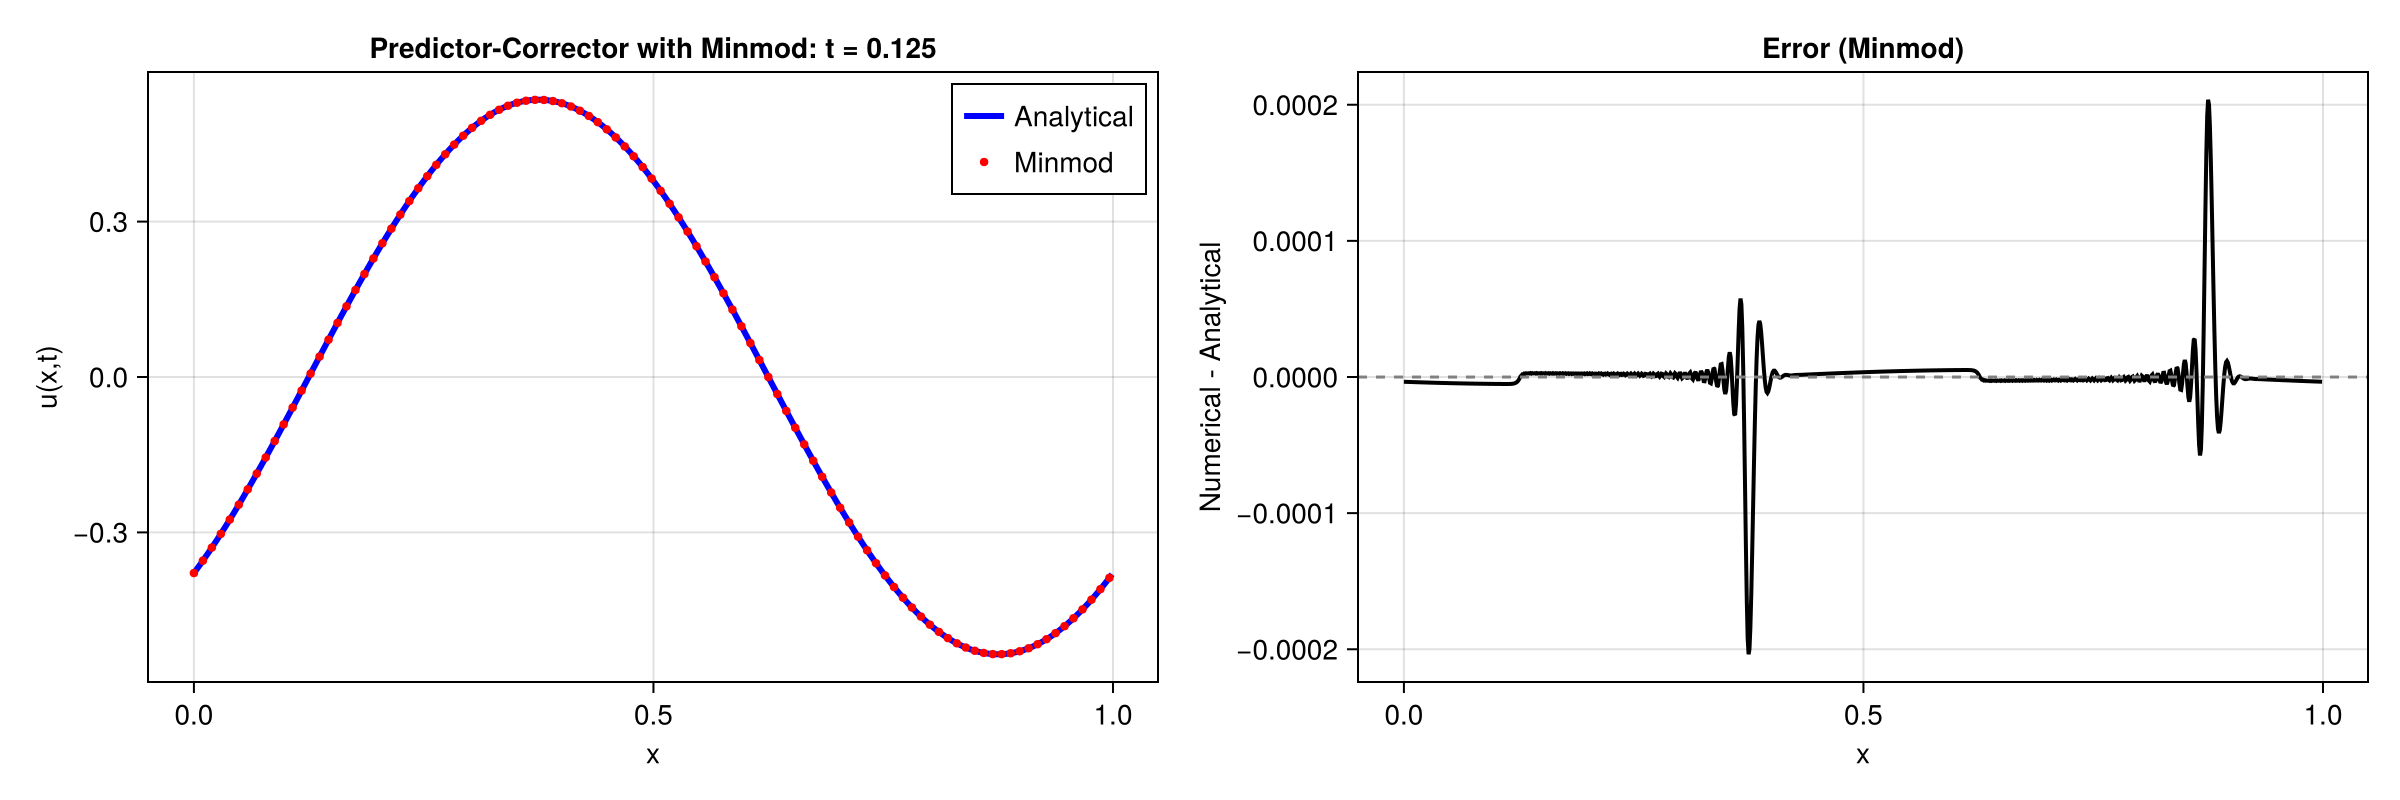

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/UjJJY/src/scenes.jl:238


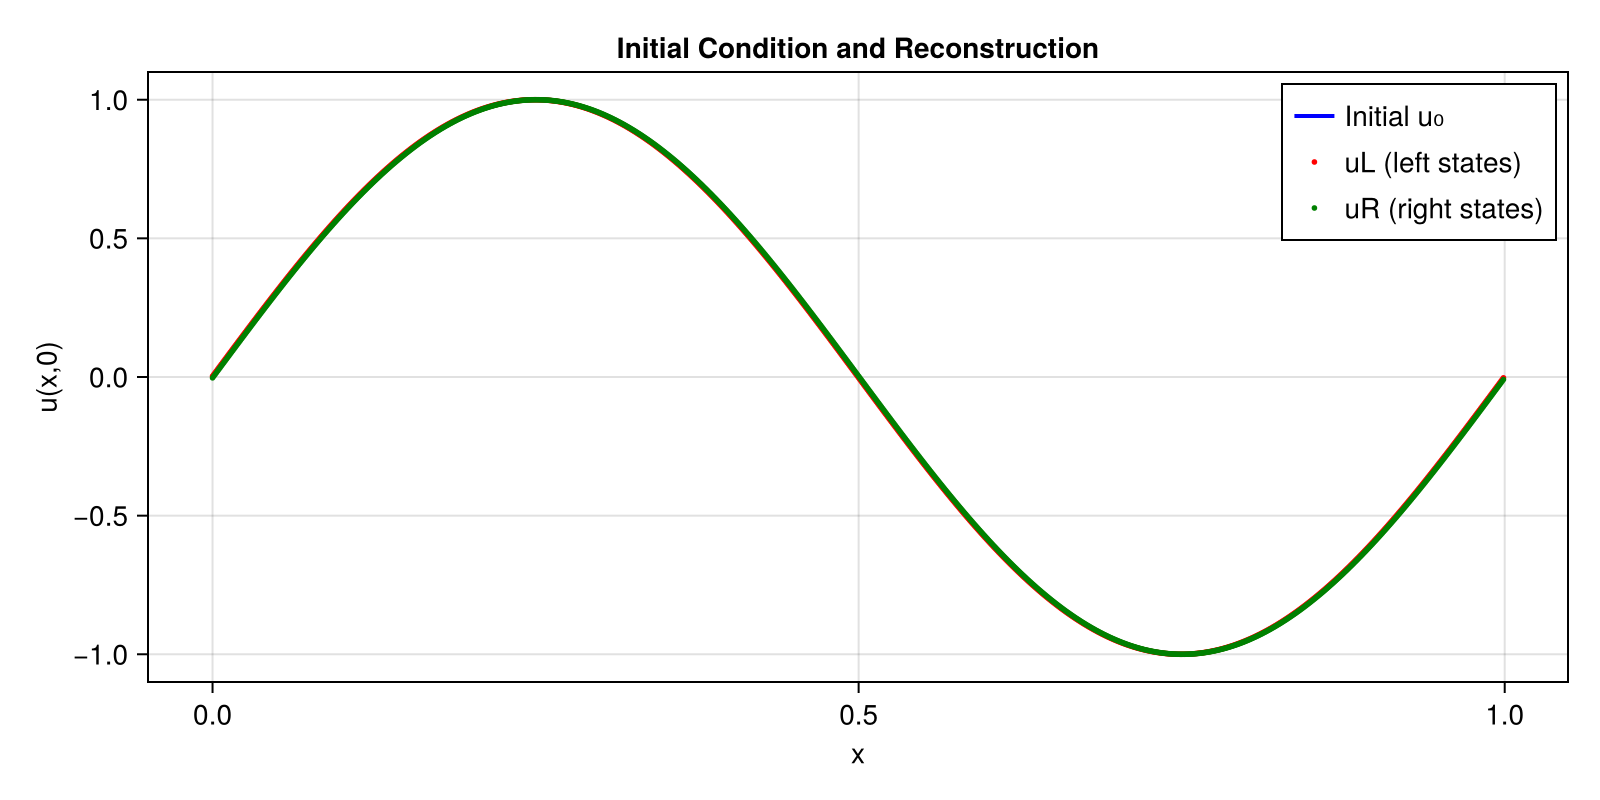

CairoMakie.Screen{IMAGE}


In [83]:
using LinearAlgebra

const λ = 5.0
const Lx = 1.0

@inline prev(i, N) = (i == 1 ? N : i - 1)
@inline nexti(i, N) = (i == N ? 1 : i + 1)

@inline function minmod(a::Float64, b::Float64)
    (a * b <= 0.0) && return 0.0
    return sign(a) * min(abs(a), abs(b))
end

"""
reconstruct_minmod(u, dx) -> uL, uR
Returns left and right states at cell interfaces using minmod reconstruction
"""
function reconstruct_minmod(u::Vector{Float64}, dx::Float64)
    N = length(u)
    uL = similar(u)  # u_{i+1/2}^L (left state at i+1/2 from cell i)
    uR = similar(u)  # u_{i-1/2}^R (right state at i-1/2 from cell i)
    
    @inbounds for i in 1:N
        im = prev(i, N)
        ip = nexti(i, N)
        
        # Slope in cell i
        σ = minmod((u[i] - u[im]) / dx, (u[ip] - u[i]) / dx)
        
        # Reconstructed states
        uL[i] = u[i] + 0.5 * σ * dx  # left state at i+1/2
        uR[i] = u[i] - 0.5 * σ * dx  # right state at i-1/2
    end
    
    return uL, uR
end

"""
flux_minmod(u, dx, i, N) -> flux at i+1/2 using minmod reconstruction
For advection speed = +1, use upwind flux: F_{i+1/2} = u_{i+1/2}^L
"""
function flux_minmod(u::Vector{Float64}, dx::Float64, i::Int, N::Int)
    uL, _ = reconstruct_minmod(u, dx)
    return uL[i]  # Upwind flux: since a=+1, use left state at i+1/2
end

"""
source_term(u, i) -> source at cell i
"""
@inline function source_term(u::Vector{Float64}, i::Int)
    return -λ * u[i]
end

"""
rhs_minmod!(du, u, dx) -> computes RHS using minmod-limited fluxes
"""
function rhs_minmod!(du::Vector{Float64}, u::Vector{Float64}, dx::Float64)
    N = length(u)
    @inbounds for i in 1:N
        im = prev(i, N)
        
        # Fluxes at interfaces using minmod reconstruction
        F_im = flux_minmod(u, dx, im, N)  # F_{i-1/2}
        F_i = flux_minmod(u, dx, i, N)    # F_{i+1/2}
        
        # Flux divergence + source
        du[i] = (F_im - F_i) / dx + source_term(u, i)
    end
    return du
end

"""
predictor_corrector_minmod_step!(u, dt, dx)

Predictor-corrector method with minmod reconstruction:
1. Predictor (half step): u* = u^n + (dt/2) * RHS(u^n)
2. Corrector (full step): u^{n+1} = u^n + dt * RHS(u*)
"""
function predictor_corrector_minmod_step!(u::Vector{Float64}, dt::Float64, dx::Float64)
    N = length(u)
    u_half = similar(u)  # u* predictor value
    rhs_temp = similar(u)
    
    # --- Predictor step (half step) ---
    # u* = u^n + (dt/2) * [ (F_{i-1/2}^n - F_{i+1/2}^n)/dx + S_i^n ]
    rhs_minmod!(rhs_temp, u, dx)
    @. u_half = u + (dt/2) * rhs_temp
    
    # --- Corrector step (full step) ---  
    # u^{n+1} = u^n + dt * [ (F_{i-1/2}^* - F_{i+1/2}^*)/dx + S_i^* ]
    rhs_minmod!(rhs_temp, u_half, dx)
    @. u = u + dt * rhs_temp
    
    return u
end

"""
evolve_predictor_corrector_minmod(u0; T, CFL)

Evolves using predictor-corrector method with minmod limiter
"""
function evolve_predictor_corrector_minmod(u0::Vector{Float64}; T::Float64=0.125, CFL::Float64=0.2)
    N = length(u0)
    dx = Lx / N
    dt = CFL * dx
    nsteps = Int(ceil(T / dt))
    dt = T / nsteps  # Adjust to hit exactly T
    
    t = 0.0
    u = copy(u0)
    
    for step in 1:nsteps
        predictor_corrector_minmod_step!(u, dt, dx)
        t += dt
    end
    
    return u, t, dt
end

# ====== Test and Compare with Analytical Solution ======
using CairoMakie

# Analytical solution for comparison
function analytical_solution(x::Vector{Float64}, t::Float64)
    # For ∂u/∂t + ∂u/∂x = -λu with u(x,0) = sin(2πx)
    # Solution: u(x,t) = e^{-λt} * sin(2π(x - t))
    return exp(-λ * t) .* sin.(2π .* (x .- t))
end

# Parameters
N = 1024
x_range = range(0, Lx, length=N+1)[1:end-1]  # Cell centers
x = collect(x_range)  # Convert to Vector{Float64}
u0 = sin.(2π .* x)
T_final = 0.125

# Numerical solution with minmod
u_num_minmod, t_final, dt_used = evolve_predictor_corrector_minmod(u0; T=T_final, CFL=0.2)

# Analytical solution
u_analytical = analytical_solution(x, t_final)

# Plot results
fig = Figure(resolution=(1200, 400))

ax1 = Axis(fig[1, 1], 
    title="Predictor-Corrector with Minmod: t = $(round(t_final, digits=4))",
    xlabel="x", 
    ylabel="u(x,t)")

lines!(ax1, x, u_analytical, label="Analytical", linewidth=3, color=:blue)
scatter!(ax1, x[1:10:end], u_num_minmod[1:10:end], label="PC - Minmod", markersize=6, color=:red)
axislegend(ax1)

ax2 = Axis(fig[1, 2], 
    title="Error (Minmod)",
    xlabel="x", 
    ylabel="Numerical - Analytical")

error_minmod = u_num_minmod .- u_analytical
lines!(ax2, x, error_minmod, linewidth=2, color=:black)
hlines!(ax2, [0.0], color=:gray, linestyle=:dash)

# Display error statistics
println("=== Minmod Predictor-Corrector Results ===")
println("Max error: $(maximum(abs.(error_minmod)))")
println("L2 error: $(norm(error_minmod))")
println("Time step: $dt_used")
println("CFL number: $(dt_used/(Lx/N))")
println("Final time: $t_final")

display(fig)

# ====== Additional: Compare initial condition to see the effect ======
fig2 = Figure(resolution=(800, 400))
ax_initial = Axis(fig2[1, 1], 
    title="Initial Condition and Reconstruction",
    xlabel="x", 
    ylabel="u(x,0)")

lines!(ax_initial, x, u0, label="Initial u₀", linewidth=2, color=:blue)

# Show reconstructed states
uL, uR = reconstruct_minmod(u0, Lx/N)
scatter!(ax_initial, x, uL, label="uL (left states)", markersize=4, color=:red)
scatter!(ax_initial, x, uR, label="uR (right states)", markersize=4, color=:green)

axislegend(ax_initial)
display(fig2)